Cette section se concentre sur le prétraitement des données puis l'entraînement d'une régression logistique. La performance du modèle est  mesurée sur les données de 2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

In [2]:
df = pd.read_csv('datatennis_prematch.csv')

In [3]:
df['year'] = df['year'].astype(int)

#Train et split
train_df = df[df['year'] < 2024]
test_df = df[df['year'] == 2024]

X_train = train_df.drop(columns=['player1_wins'])
y_train = train_df['player1_wins']

X_test = test_df.drop(columns=['player1_wins'])
y_test = test_df['player1_wins']

print(f"Dimensions train : {X_train.shape}, test : {X_test.shape}")

Dimensions train : (34250, 33), test : (2605, 33)


In [ ]:
# On enlève les colonnes inutiles
cols_to_drop = [
    'match_id', 'player1_name', 'player2_name',
    'tourney_id', 'tourney_date',
    'player1_id', 'player2_id',
]
X_train_clean = X_train.drop(columns=cols_to_drop)
X_test_clean = X_test.drop(columns=cols_to_drop)

num_cols = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train_clean.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=5000, solver='saga')) 
])

param_grid = {
    'clf__C': [0.01],
    'clf__penalty': ['l1']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_clean, y_train)

print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score de validation : {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs hyperparamètres : {'clf__C': 0.01, 'clf__penalty': 'l1'}
Meilleur score de validation : 0.6631


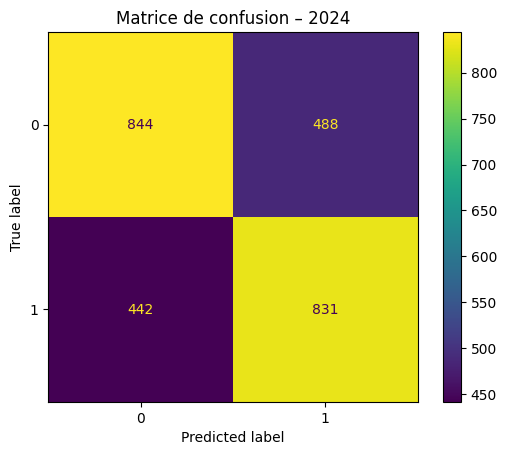

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1332
           1       0.63      0.65      0.64      1273

    accuracy                           0.64      2605
   macro avg       0.64      0.64      0.64      2605
weighted avg       0.64      0.64      0.64      2605



In [5]:
# Prédictions sur le jeu de test
y_pred = grid_search.predict(X_test_clean)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matrice de confusion – 2024")
plt.show()

print(classification_report(y_test, y_pred))